## Imports

In [4]:
from sklearn.preprocessing  import RobustScaler
from sklearn.preprocessing  import OrdinalEncoder
from sklearn.preprocessing  import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

import pandas as pd
import seaborn as sns
from umap import UMAP
import numpy as np
import matplotlib.pyplot as plt

sns.set_theme(context="paper", style="ticks")
random_state = 42

Load data

In [5]:
train = pd.read_csv("data\\train.csv")
test = pd.read_csv("data\\test.csv")

test_ID = test.PassengerId

Proprocessing

In [6]:
oh_enc = OneHotEncoder(sparse=False)
ordinal_enc = OrdinalEncoder(categories=[["A", "B", "C", "D", "E", "F", "G", "T", np.nan]])

ct = ColumnTransformer(
    [("oh", oh_enc, ["Sex", "Embarked"]),
    ("ord", ordinal_enc, ["Deck"])]
)

In [7]:
train["Deck"] = pd.DataFrame(train.Cabin.str.extract("([A-Z])", expand=False))#.to_numpy().reshape(-1, 1)
ct.fit_transform(train)

train_coded = pd.DataFrame(
    ct.fit_transform(train),
    # columns=train.columns
)

drop_cols = ["Ticket", "Cabin", "Name", "PassengerId", "Sex", "Embarked", "Deck"]
train.drop(labels=drop_cols, axis=1, inplace=True)

In [8]:
train_coded

,0,1,2,3,4,5,6
0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0
2,1.0,0.0,0.0,0.0,1.0,0.0,NaN
3,1.0,0.0,0.0,0.0,1.0,0.0,2.0
4,0.0,1.0,0.0,0.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,NaN
887,1.0,0.0,0.0,0.0,1.0,0.0,1.0
888,1.0,0.0,0.0,0.0,1.0,0.0,NaN
889,0.0,1.0,1.0,0.0,0.0,0.0,2.0


In [ ]:
train_y = train.Survived
train_X = train.drop("Survived", axis=1)

In [ ]:
estimators = [
    ("knnc", KNeighborsClassifier(
        weights="distance",
        n_neighbors=100,
        n_jobs=-1
    )),
    ("gpc", GaussianProcessClassifier(
        random_state=random_state,
        warm_start=True
    )),
    ("rfc", RandomForestClassifier(
        random_state=random_state,
        class_weight="balanced_subsample",
        n_jobs=-1
    )),
    ("SVC", LinearSVC(
        max_iter=100000,
        random_state=random_state
    )),
    ("gnb", GaussianNB())
]

In [ ]:
scaler = RobustScaler(
    unit_variance=True
)

reducer = UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    target_weight=0.5,
    metric="correlation",
    random_state=random_state
)

class_comp = StackingClassifier(
    estimators=estimators,
    # final_estimator=final_estimator,
    n_jobs=-1,
    verbose=0,
)

In [ ]:
pipeline = make_pipeline(
    scaler,
    reducer,
    class_comp
)

In [ ]:
pipeline.fit(
    X=train_X,
    y=train_y
)

pred_y = pipeline.predict(test)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
proba = 1 - 2 * np.sqrt(
    np.product(
        pipeline.predict_proba(test), axis=1))

# proba = 1 - pipeline.predict_proba(test).max(axis=1)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
proba = pipeline.predict_proba(test)
entropy = -np.sum(np.log2(proba) * proba, axis=1)

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Plot training data

<AxesSubplot:>

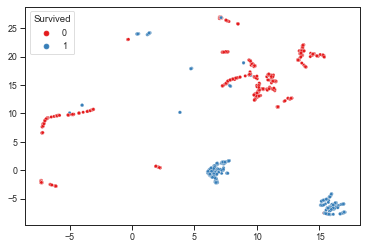

In [ ]:
sns.scatterplot(
    x=pipeline["umap"].embedding_[:,0],
    y=pipeline["umap"].embedding_[:,1],
    hue=train_y,
    # alpha=proba,
    palette="Set1",
    s=10
)

Plot test data

C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\tools\miniconda3\lib\site-packages\seaborn\relational.py:654: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  kws["alpha"] = 1 if self.alpha == "auto" else self.alpha


<AxesSubplot:>

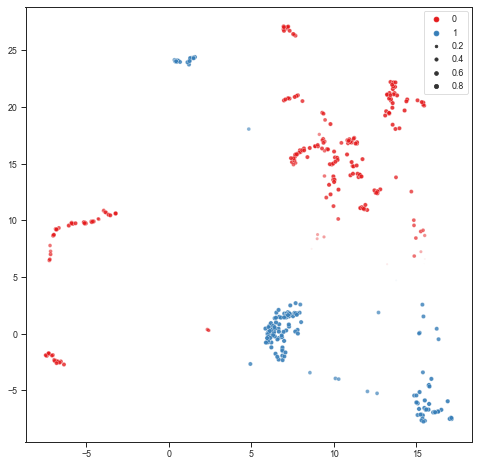

In [ ]:
plt.figure(figsize=(8,8))
sns.scatterplot(
    x=pipeline[:2].transform(X=test)[:,0],
    y=pipeline[:2].transform(X=test)[:,1],
    hue=pred_y,
    palette="Set1",
    size=1-entropy,
    alpha=1-entropy,
    sizes=(3,20),
    s=10
)

<AxesSubplot:ylabel='Percent'>

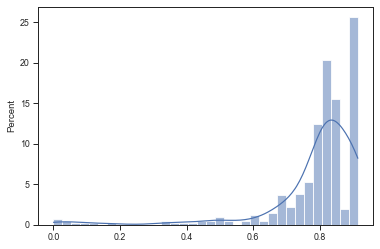

In [ ]:
sns.histplot(
    1-entropy,
    # cumulative=True,
    kde=True,
    stat="percent")

Save predictions as csv

In [ ]:
submission = pd.DataFrame(columns=["PassengerId", "Survived"], data=zip(test_ID, pred_y))
submission.to_csv("submission.csv", index=False)

In [ ]:
data = pd.read_csv("data\\train.csv")
X_data = data.drop("Survived", axis=1)
y_data = data.Survived

X_train, X_test, y_train, y_test = train_test_split(
    X_data, 
    y_data,
    random_state=random_state)

In [ ]:
X_train = preprocess(X_train, fit=True)

TypeError: preprocess() missing 2 required positional arguments: 'oh_enc' and 'ordinal_enc'